<a href="https://colab.research.google.com/github/konstanzer/deep-learning/blob/master/mobile_net_birds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transfer Learning using MobileNet V2 and TensorFlow
Based on https://towardsdatascience.com/transfer-learning-using-mobilenet-and-keras-c75daf7ff299

In [1]:
import tensorflow as tf
import keras
import tensorflow.keras.layers as tfl
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image

img_path='/content/drive/MyDrive/Colab Notebooks/data/birds/'

Rather than manually downloading images for fine-tuned learning, use Bing Image Search via this import.

In [2]:
!pip install bing-image-downloader
from bing_image_downloader import downloader

#MobileNet

In Ferhat Kulfaz's notebook, he shows an example of using MobileNet to classify images of dogs and an example when it misclassifies an image of a blue tit. He retrains MobileNet via transfer learning and correctly classifies the tit. Only two classifiers are employed but this can be extended to as many as you want, limited only by hardware and time available.

The source paper for MobileNet is located here: https://arxiv.org/pdf/1704.04861.pdf

MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications, Howard et al, 2017.

MobileNet is a lightweight architecture. It uses depthwise separable convolutions - separate convolutions on each colour channel rather than flattening all three. This has the effect of filtering the input channels.

"For MobileNets the depthwise convolution applies a single filter to each input channel. The pointwise convolution then applies a 1×1 convolution to combine the outputs the depthwise convolution. A standard convolution both filters and combines inputs into a new set of outputs in one step. The depthwise separable convolution splits this into two layers, a separate layer for filtering and a separate layer for combining. This factorization has the effect of drastically reducing computation and model size.”

In [3]:
mobile = mobilenet_v2.MobileNetV2()

14548992/14536120 [==============================] - 0s 0us/step


In [4]:
def prepare_image(file):
  img = image.load_img(file, target_size=(224, 224))
  img_array = image.img_to_array(img)
  img_array_expanded = np.expand_dims(img_array, axis=0)
  return mobilenet_v2.preprocess_input(img_array_expanded)

49152/35363 [=========================================] - 0s 0us/step
[('n02012849', 'crane', 0.8826696), ('n01855672', 'goose', 0.0080727665), ('n01616318', 'vulture', 0.0057985783)]


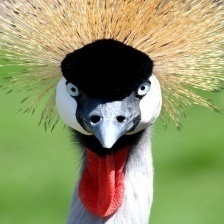

In [5]:
filename = img_path+'images to test/2.jpg'
print(mobilenet_v2.decode_predictions(mobile.predict(prepare_image(filename)))[0][0:3])
Image(filename)

[('n01532829', 'house_finch', 0.3125402), ('n01828970', 'bee_eater', 0.08511834), ('n01560419', 'bulbul', 0.020342598)]


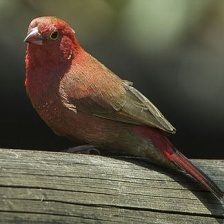

In [6]:
filename = img_path+'images to test/1.jpg'
print(mobilenet_v2.decode_predictions(mobile.predict(prepare_image(filename)))[0][0:3])
Image(filename)

# Transfer learning
Let us now manipulate the MobileNet architecture while retraining the top few layers. To do this, we need to train it on some images. Here I will train it on scarlet tanagers and grey crowned cranes.

In [7]:
#you'll have to delete a few images after they download
new_data = False
if new_data==True:
  downloader.download("scarlet tanager", limit=50, output_dir=img_path+'datasets')
  downloader.download("grey crowned crane", limit=50, output_dir=img_path+'datasets')

In [8]:
#hyperparameters
BATCH_SIZE = 32
IMG_SIZE = (128, 128) #96, 128, 160, 192, or 224
IMG_SHAPE = IMG_SIZE + (3,)
freeze_layers = 130
learning_rate = .0001
epochs = 7

In [9]:
#Generate batches of tensor image data with real-time data augmentation.
train_datagen = image.ImageDataGenerator(horizontal_flip=True,
                                         rotation_range=20,
                                         preprocessing_function=mobilenet_v2.preprocess_input)

train_generator = train_datagen.flow_from_directory(img_path+'datasets',
                                                    target_size=IMG_SIZE,
                                                    color_mode='rgb',
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    shuffle=True)
SAMP_SIZE = train_generator.n
class_names = list(train_generator.class_indices.keys())
n_classes = len(class_names)

Found 76 images belonging to 2 classes.


Lets now re-use MobileNet as it is quite lightweight (17Mb), freeze the base layers and lets add and train the top few layers. Note I shall only train two classifiers, the tanager and the crane.

In [10]:
base_model = mobilenet_v2.MobileNetV2(input_shape=IMG_SHAPE,
                                      weights='imagenet',
                                      include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.
base_model.trainable = False
x = base_model.output
x = tfl.GlobalAveragePooling2D()(x)
x = tfl.Dropout(.2)(x)
outputs = tfl.Dense(n_classes, activation='softmax')(x)

9420800/9406464 [==============================] - 0s 0us/step


In [11]:
model = tf.keras.Model(inputs=base_model.input, outputs=outputs)
print('Total layers :', len(model.layers))
for layer in model.layers[freeze_layers:]:
  layer.trainable=True
print('Thawed (trainable) layers :', len(model.layers)-freeze_layers)

Total layers : 157
Thawed (trainable) layers : 27


In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_generator,
          steps_per_epoch=SAMP_SIZE//BATCH_SIZE,
          epochs=epochs)

Epoch 1/7
2/2 [==============================] - 8s 560ms/step - loss: 0.7555 - accuracy: 0.5682
Epoch 2/7
2/2 [==============================] - 2s 928ms/step - loss: 0.4443 - accuracy: 0.7727
Epoch 3/7
2/2 [==============================] - 2s 701ms/step - loss: 0.2246 - accuracy: 0.9375
Epoch 4/7
2/2 [==============================] - 2s 1s/step - loss: 0.0876 - accuracy: 1.0000
Epoch 5/7
2/2 [==============================] - 2s 1s/step - loss: 0.0598 - accuracy: 0.9844
Epoch 6/7
2/2 [==============================] - 2s 756ms/step - loss: 0.0257 - accuracy: 1.0000
Epoch 7/7
2/2 [==============================] - 1s 772ms/step - loss: 0.0204 - accuracy: 1.0000


In [27]:
def predict_image(img_path, mdl, show_vector=True, show_channels=False):
  img = image.load_img(img_path, target_size=IMG_SIZE)
  img_tensor = image.img_to_array(img) # (height, width, channels)

  if show_channels:
    f, ax = plt.subplots(1, 3, figsize=(8,8))
    for i, subplot in zip(range(3), ax):
        temp = np.zeros(img_tensor.shape, dtype='uint8')
        temp[:,:,i] = img_tensor[:,:,i]
        subplot.imshow(temp)
        subplot.set_axis_off()
    plt.show()

  img_tensor = np.expand_dims(img_tensor, axis=0) #(1 [batch_size], height, width, channels), the model expects this shape
  img_tensor /= 255. #classifies wildly if you forget this step
  
  if not show_channels:
    plt.imshow(img_tensor[0])                           
    plt.axis('off')
    plt.show()

  prediction = mdl(img_tensor)
  if show_vector:
    print("Class prediction vector = ", np.round(prediction.numpy(),3)[0])
  print("Class: ", class_names[np.argmax(prediction)])

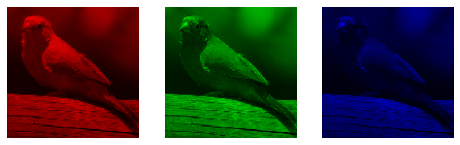

Class prediction vector =  [0.0014 0.9986]
Class:  scarlet tanager


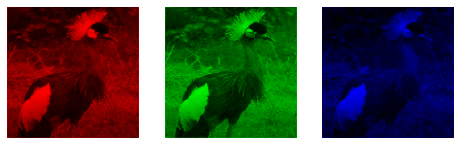

Class prediction vector =  [0.9882 0.0118]
Class:  grey crowned crane


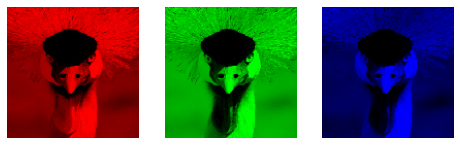

Class prediction vector =  [0.9827 0.0173]
Class:  grey crowned crane


In [14]:
#brighter indicates that channel is more active
for i in ['1', '3', '2']:
  predict_image(img_path+f'images to test/{i}.jpg', model, show_channels=True)

In [15]:
#model.summary()

#Multiclass

In [18]:
#hyperparameters
BATCH_SIZE = 32
IMG_SIZE = (128, 128)
IMG_SHAPE = IMG_SIZE + (3,)
freeze_layers = 130
learning_rate = .0001
epochs = 1

In [17]:
train_datagen = image.ImageDataGenerator(horizontal_flip=True,
                                         rotation_range=20,
                                         preprocessing_function=mobilenet_v2.preprocess_input)
#one minute to run
train_generator = train_datagen.flow_from_directory(img_path+'train', #315 bird species, 45980 training images
                                                    target_size=IMG_SIZE,
                                                    color_mode='rgb',
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    shuffle=True)
SAMP_SIZE = train_generator.n
class_names = list(train_generator.class_indices.keys())
n_classes = len(class_names)

Found 45980 images belonging to 315 classes.


In [19]:
base_model = mobilenet_v2.MobileNetV2(input_shape=IMG_SHAPE,
                                      weights='imagenet',
                                      include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.
base_model.trainable = False
x = base_model.output
x = tfl.GlobalAveragePooling2D()(x)
x = tfl.Dropout(.2)(x)
outputs = tfl.Dense(n_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=outputs)
print('Total layers :', len(model.layers))
for layer in model.layers[freeze_layers:]:
  layer.trainable=True
print('Thawed (trainable) layers :', len(model.layers)-freeze_layers)

Total layers : 157
Thawed (trainable) layers : 27


In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_generator,
          steps_per_epoch=SAMP_SIZE//BATCH_SIZE,
          epochs=epochs) #3 hours per epoch

1436/1436 [==============================] - 9327s 6s/step - loss: 2.0765 - accuracy: 0.5816


In [22]:
model.save(img_path+'mobilenet-birds.h5')
model =  keras.models.load_model(img_path+'mobilenet-birds.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


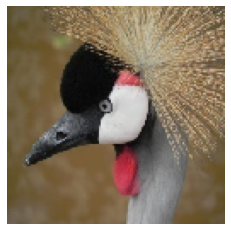

Class:  AFRICAN CROWNED CRANE


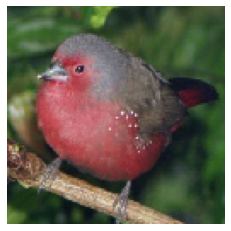

Class:  AFRICAN FIREFINCH


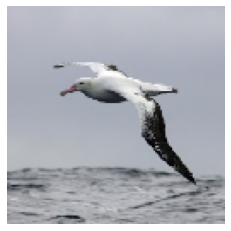

Class:  ALBATROSS


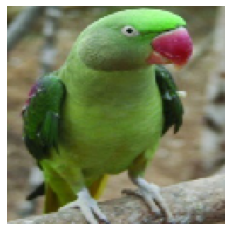

Class:  ALEXANDRINE PARAKEET


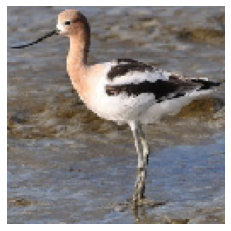

Class:  AMERICAN AVOCET


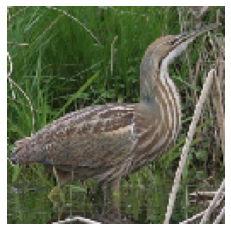

Class:  AMERICAN BITTERN


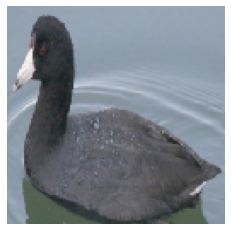

Class:  AMERICAN COOT


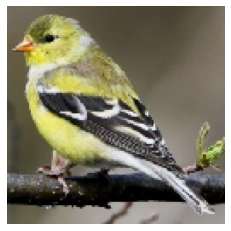

Class:  AMERICAN GOLDFINCH


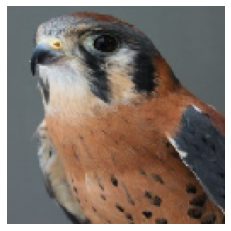

Class:  AMERICAN KESTREL


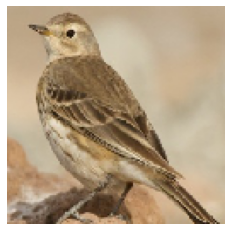

Class:  AMERICAN PIPIT


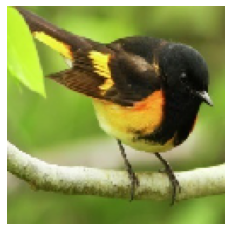

Class:  AMERICAN REDSTART


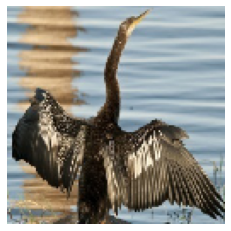

Class:  ANHINGA


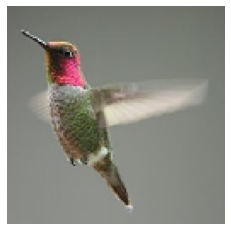

Class:  ANNAS HUMMINGBIRD


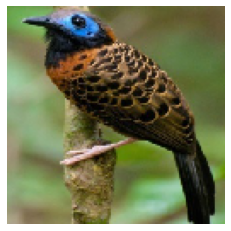

Class:  ANTBIRD


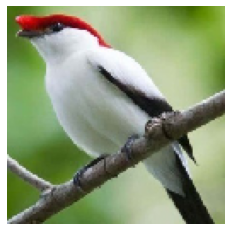

Class:  ARARIPE MANAKIN


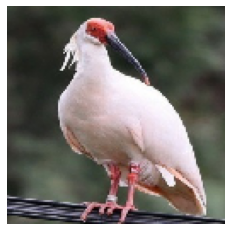

Class:  ASIAN CRESTED IBIS


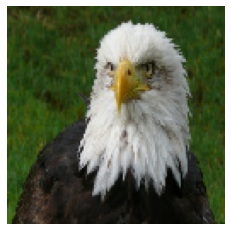

Class:  BALD EAGLE


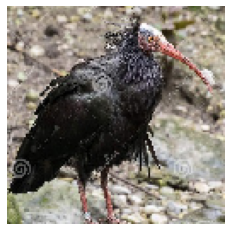

Class:  BALD IBIS


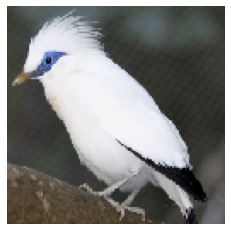

Class:  BALI STARLING


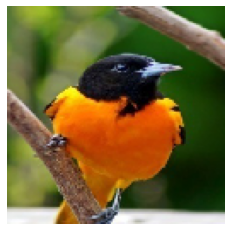

Class:  BALTIMORE ORIOLE


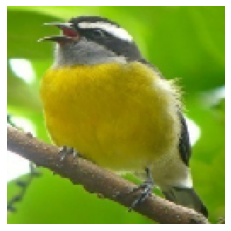

Class:  BANANAQUIT


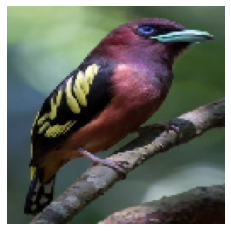

Class:  BANDED BROADBILL


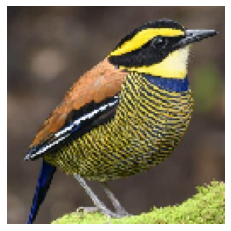

Class:  BANDED PITA


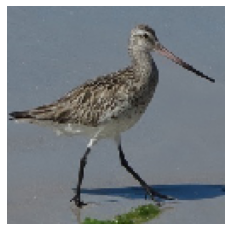

Class:  BAR-TAILED GODWIT


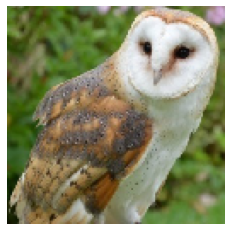

Class:  BARN OWL


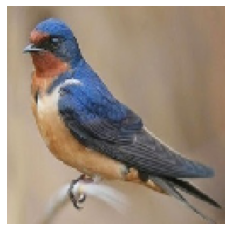

Class:  EASTERN BLUEBIRD


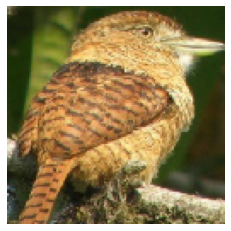

Class:  NORTHERN GOSHAWK


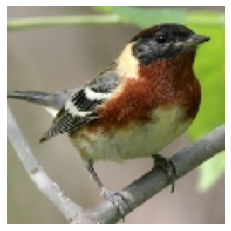

Class:  BAY-BREASTED WARBLER


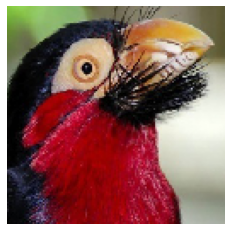

Class:  MANDRIN DUCK


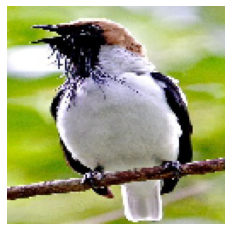

Class:  BEARDED BELLBIRD


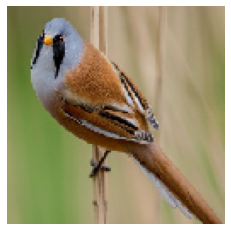

Class:  BEARDED REEDLING


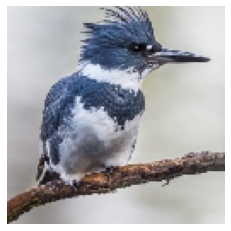

Class:  BELTED KINGFISHER


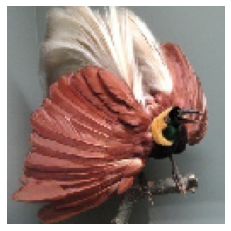

Class:  BIRD OF PARADISE


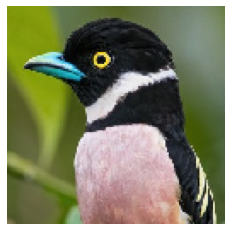

Class:  BLACK & YELLOW bROADBILL


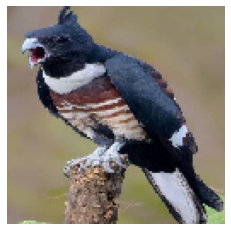

Class:  GO AWAY BIRD


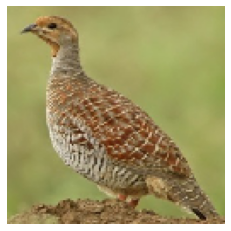

Class:  BLUE GROUSE


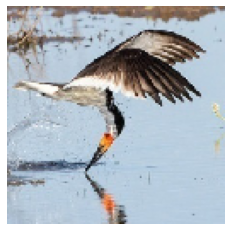

Class:  ASIAN CRESTED IBIS


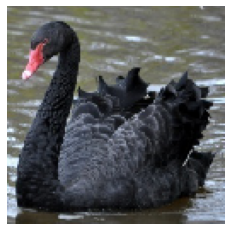

Class:  BLACK SWAN


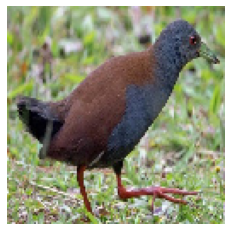

Class:  BLACK TAIL CRAKE


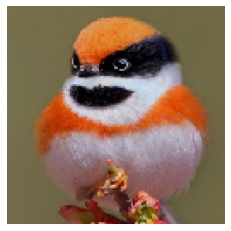

Class:  BLACK THROATED BUSHTIT


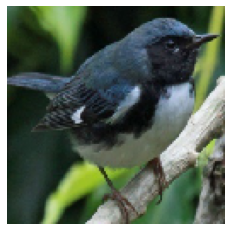

Class:  BLACK THROATED WARBLER


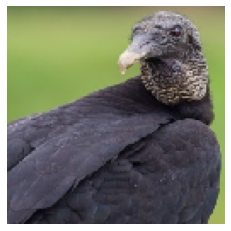

Class:  BLUE COAU


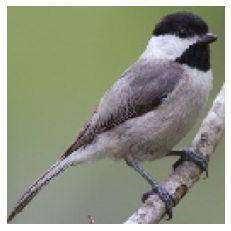

Class:  BLACK-CAPPED CHICKADEE


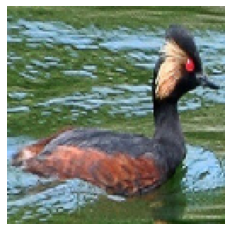

Class:  BLACK-NECKED GREBE


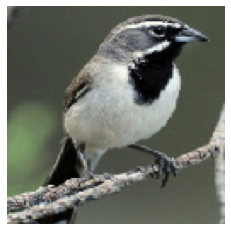

Class:  BLACK-THROATED SPARROW


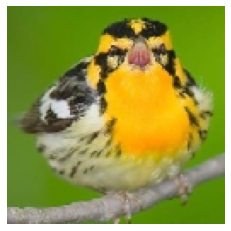

Class:  TOWNSENDS WARBLER


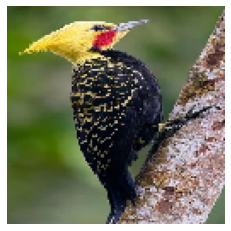

Class:  BLONDE CRESTED WOODPECKER


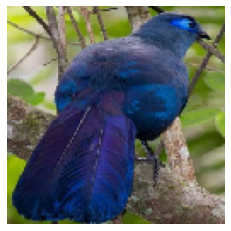

Class:  BLUE COAU


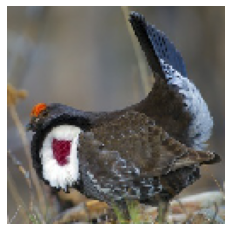

Class:  BLUE GROUSE


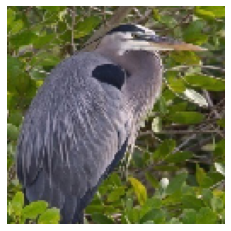

Class:  BLUE HERON


In [33]:
for species in class_names[:50]:
  predict_image(img_path+f'test/{species}/1.jpg', model, show_vector=False)

In [30]:
model2 =  keras.models.load_model(img_path+'efficientnet-birds.h5')